## Install and import libraries

In [ ]:
import pandas as pd
import numpy as np
import numbers
import re

import matplotlib.pyplot as plt 
import seaborn as sns

import sklearn
from sklearn.decomposition import PCA as sk_pca
from sklearn.feature_selection import RFECV, VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures, scale
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import RFECV, VarianceThreshold
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVR
import math
from xgboost import XGBRegressor

import warnings # supress warnings
warnings.filterwarnings('ignore')

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## Read Data

In [ ]:
path = '/content/drive/MyDrive/MasterInteligenciaArtificial/TFM/'

In [ ]:
filename = 'Database_64-60m.xlsx'
xl_file = pd.ExcelFile(path + 'Data/' + filename)

dfs = {sheet_name: xl_file.parse(sheet_name) 
          for sheet_name in xl_file.sheet_names}

sheets = list(dfs.keys())

df_total = dfs['Hist_Clin']
for df in sheets:
    df_aux = dfs[df]
    if (df == 'Notas') | (df == 'Hist_Clin'):
        continue
    if df == 'Salud':
        df_aux = df_aux.iloc[:,:-2]
    df_total = pd.merge(df_total, df_aux, on="Patient ID")


filename_master = 'Dataset_Masterfile.xlsx'
xl_file = pd.ExcelFile(path + 'Data/' + filename_master)

dfs = {sheet_name: xl_file.parse(sheet_name) for sheet_name in xl_file.sheet_names}
df_target = dfs['1_Var_CatYNum']
df_target = df_target.iloc[:60,:]

# df_total = pd.merge(df_total, df_target.loc[:,['ID_Muestra', 'DNAmAge']], left_on="Patient ID", right_on='ID_Muestra')

df_total.iloc[:3,:]


,Patient ID,Alergia_Gluten,Alergia_Lactosa,Alergia_Otra,Alergia_medicamento,Depresión,Ansiedad,ManchaFacialBenigna,HipertensionArterial,BloqueoAVCompleto,...,Molesto/a,Descontrol,Nervioso/a,Seguro/aResolverProblem,SensacionCosasIbanBien,NoPoderConTodo,NoControlarIrratabilidad,EstarAlTantoDeTodo,Enfadado/aPorCosasFueraControl,NoPoderSuperarDificultades
0,1,NaN,NaN,NaN,NaN,Si,Si,Si,NaN,NaN,...,Nunca,Nunca,Algunos días,Más de la mitad de los días,Más de la mitad de los días,Nunca,Más de la mitad de los días,Más de la mitad de los días,Nunca,Nunca
1,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Si,Si,...,Nunca,Nunca,Nunca,Nunca,Más de la mitad de los días,Nunca,Más de la mitad de los días,Más de la mitad de los días,Algunos días,Nunca
2,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Si,NaN,...,Algunos días,Nunca,Nunca,Nunca,Algunos días,Nunca,Prácticamente cada día,Prácticamente cada día,Algunos días,Nunca


## Clean data

#### Remove columns with constant variable

In [ ]:
for column in df_total.columns:
    if len(df_total[column].unique()) == 1:
        df_total = df_total.drop(columns = [column])

#### Convert values of columns in 0 and 1 if it only has two different values

In [ ]:
for index_column in range(1, df_total.shape[1]):
    list_unique_values = df_total[df_total.columns[index_column]].unique()
    if len(list_unique_values) == 2:
        if list_unique_values[0] == list_unique_values[0]:
            df_total.loc[df_total[df_total.columns[index_column]] == list_unique_values[0], df_total.columns[index_column]] = 0
        else:           
            df_total.loc[df_total[df_total.columns[index_column]].isna(), df_total.columns[index_column]] = 0
        if list_unique_values[1] == list_unique_values[1]:
            df_total.loc[df_total[df_total.columns[index_column]] == list_unique_values[1], df_total.columns[index_column]] = 1
        else:
            df_total.loc[df_total[df_total.columns[index_column]].isna(), df_total.columns[index_column]] = 1

#### Check columns with non numerical values

In [ ]:
list_columns_non_numerical_values = []
for index_column in range(1, df_total.shape[1]):
    list_unique_values = df_total[df_total.columns[index_column]].unique()
    try:
      numeric_values = [float(i) for i in list_unique_values]
    except:
      list_columns_non_numerical_values.append(index_column)
print("There are " + str(len(list_columns_non_numerical_values)) + " columns with non numerical data")

There are 83 columns with non numerical data


#### If there are 5 or less different values, convert column to that number of columns with binary values 

In [ ]:
df_with_dummies = df_total.copy()
for index_column in list_columns_non_numerical_values:
    list_unique_values = df_total[df_total.columns[index_column]].unique()
    if 2 < len(list_unique_values) <= 5:
        column_name = df_total.columns[index_column]
        for value in list_unique_values:
            new_column = pd.DataFrame(df_total.loc[:, column_name])
            if value == value:
                new_column = new_column.rename(columns={column_name: column_name + '_' + str(value)})
                df_with_dummies = pd.concat([df_with_dummies, new_column], 1)
                df_with_dummies.loc[df_with_dummies[column_name + '_' + str(value)] != value, column_name + '_' + str(value)] = 0
                df_with_dummies.loc[df_with_dummies[column_name + '_' + str(value)] == value, column_name + '_' + str(value)] = 1
            else:           
                new_column = new_column.rename(columns={column_name: column_name + '_nan'})
                df_with_dummies = pd.concat([df_with_dummies, new_column], 1)
                df_with_dummies.loc[df_with_dummies[df_with_dummies.columns[index_column]].isna(), column_name + '_nan'] = 1
                df_with_dummies.loc[df_with_dummies[df_with_dummies.columns[index_column]].isna() == False, column_name + '_nan'] = 0
for index_column in list_columns_non_numerical_values:
    column_name = df_total.columns[index_column]
    df_with_dummies = df_with_dummies.drop(columns = [column_name])

df_with_dummies.shape

(60, 378)

#### Return check columns with non numerical values

In [ ]:
list_columns_non_numerical_values = []
for index_column in range(1, df_with_dummies.shape[1]):
    list_unique_values = df_with_dummies[df_with_dummies.columns[index_column]].unique()
    try:
      numeric_values = [float(i) for i in list_unique_values]
    except:
      list_columns_non_numerical_values.append(index_column)
print("There are " + str(len(list_columns_non_numerical_values)) + " columns with non numerical data")

There are 0 columns with non numerical data


#### Normalize column values

In [ ]:
for i in range(1, df_with_dummies.shape[1]):
    column_name = df_with_dummies.columns[index_column]
    df_with_dummies[column_name] = (df_with_dummies[column_name] - df_with_dummies[column_name].min()) / (df_with_dummies[column_name].max() - df_with_dummies[column_name].min())
df_with_dummies.iloc[:3,:]

,Patient ID,Alergia_Gluten,Alergia_Lactosa,Alergia_Otra,Depresión,Ansiedad,ManchaFacialBenigna,HipertensionArterial,BloqueoAVCompleto,EnfermedadRenalCronica,...,EstarAlTantoDeTodo_Prácticamente cada día,EstarAlTantoDeTodo_Nunca,EstarAlTantoDeTodo_Algunos días,EstarAlTantoDeTodo_Más de la mitad de los días,Enfadado/aPorCosasFueraControl_Nunca,Enfadado/aPorCosasFueraControl_Algunos días,Enfadado/aPorCosasFueraControl_Más de la mitad de los días,NoPoderSuperarDificultades_Nunca,NoPoderSuperarDificultades_Algunos días,NoPoderSuperarDificultades_Más de la mitad de los días
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0.0
1,2,0,0,0,1,1,1,1,1,1,...,0,0,0,0,0,1,0,1,0,0.0
2,3,0,0,0,1,1,1,1,0,0,...,1,0,0,0,0,1,0,1,0,0.0


#### Save cleaned Database_64-60m

In [ ]:
df_with_dummies.to_csv(path + 'Data/Database_64-60m_clean.csv', index = False)

## Load data

In [ ]:
df_data = pd.read_csv(path + 'Data/Database_64-60m_clean.csv')
df_data_no_id_patient = df_data.iloc[:,1:]
df_data_id_patient = pd.DataFrame(df_data.iloc[:,0])

df_target['ID_Muestra'] = df_target['ID_Muestra'].astype(int)
df_target = df_target.loc[:,['ID_Muestra', 'DNAmAge']]

In [ ]:
df_edad = pd.merge(df_data, df_target.loc[:,['ID_Muestra', 'DNAmAge']], left_on="Patient ID", right_on='ID_Muestra')
#df_edad
df_edad = df_edad.loc[:,['Edad', 'DNAmAge']]

## Reduce dimensionality

#### Drop columns with small variance

In [ ]:
selector = VarianceThreshold(0.05)
selector.fit(df_data_no_id_patient)
df_data_columns_big_variance = df_data_no_id_patient[df_data_no_id_patient.columns[selector.get_support(indices=True)]]
print('Number of columns before dropping by variance threshold: ', df_data_no_id_patient.shape[1])
print('number of columns after dropping by variance threshold:', df_data_columns_big_variance.shape[1])

Number of columns before dropping by variance threshold:  377
number of columns after dropping by variance threshold: 199


#### Drop columns for feature selection

========== LinearRegression ==========
RMSE in training: 2.5916710272860977e-28
RMSE in valid: 25.45574511102179
Show top 10 important features:


,feature_importance,ranking
Edad,0.572628,1.0
TamLeg_Medio,0.481522,2.0
TamVerdCru_Medio,0.468718,3.0
TamCarPro_Medio,0.465194,4.0
RacPastDia,0.420182,5.0
TamQuesSua_Pequeño,0.408831,6.0
TamVerdCru_Pequeño,0.402925,7.0
RacLegSem_4,0.384153,8.0
TamVasoLech_Grande,0.356086,9.0
RacLegSem_2,0.348908,10.0


========== SVM ==========
RMSE in training: 0.01004398388682923
RMSE in valid: 25.321652466092015
Show top 10 important features:


,feature_importance,ranking
Edad,0.572920,1.0
TamLeg_Medio,0.472038,2.0
TamCarPro_Medio,0.454357,3.0
TamVerdCru_Medio,0.451665,4.0
RacPastDia,0.413954,5.0
TamQuesSua_Pequeño,0.394866,6.0
TamVerdCru_Pequeño,0.386391,7.0
RacLegSem_4,0.369559,8.0
TamVasoLech_Grande,0.344278,9.0
DuermeSiesta_Nunca,0.340756,10.0


========== RandomForestRegressor ==========
RMSE in training: 5.001976325001453
RMSE in valid: 69.90495551237154
Show top 10 important features:


,feature_importance,ranking
Edad,0.761088,1.0
TamVerdCoc_Pequeño,0.043351,2.0
DiasActModeradas_1-2,0.021412,3.0
TamVerdCoc_Medio,0.020534,4.0
EstadoCivil_Soltero/a,0.011125,5.0
RacCarRoSem,0.010047,6.0
Hijos,0.009821,7.0
DiasActModeradas_3-4,0.008940,8.0
Ingresos_0-15000,0.008589,9.0
TamQuesSua_Pequeño,0.007804,10.0


========== XGBoostRegressor ==========
[13:23:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
RMSE in training: 0.007655582363729356
RMSE in valid: 44.20220810371883
Show top 10 important features:


,feature_importance,ranking
Edad,0.394056,1.0
Adiro,0.159347,2.0
RacPizzaSem,0.157284,3.0
TranquiloAlDespertar_Siempre,0.146747,4.0
HipertensionArterial,0.035440,5.0
TamGall_Pequeño,0.015570,6.0
TamVasoLech_Medio,0.013775,7.0
TamVerdCru_Pequeño,0.012867,8.0
HacerMenos,0.012471,9.0
TamPast_Medio,0.010432,10.0


Número total de features seleccionadas:  58


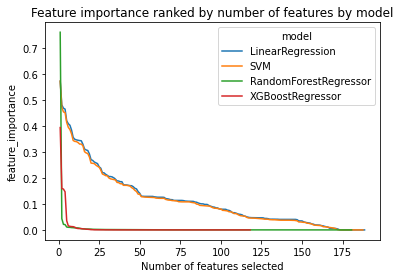

In [ ]:
df_data_feature_selection = df_data_columns_big_variance.copy() #deep copy
y_train = list(df_target['DNAmAge'])

regex = re.compile(r"\[|\]|<", re.IGNORECASE)

df_data_feature_selection.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in df_data_feature_selection.columns.values]

X_model, X_valid, y_model, y_valid = train_test_split(df_data_feature_selection, y_train, random_state=42, test_size=0.75)

random_state = 42
model_dict = {'LinearRegression': LinearRegression(),
              'SVM': SVR(kernel = 'linear'),
              'RandomForestRegressor': RandomForestRegressor(random_state=random_state, n_jobs=-1),
              'XGBoostRegressor': XGBRegressor(objective= 'reg:linear')

             }
estimator_dict = {}
list_features = []
importance_fatures_sorted_all = pd.DataFrame()
for model_name, model in model_dict.items():
    print('='*10, model_name, '='*10)
    model.fit(X_model, y_model)
    print('RMSE in training:', mean_squared_error(model.predict(X_model), y_model))
    print('RMSE in valid:', mean_squared_error(model.predict(X_valid), y_valid))
    importance_values = np.absolute(model.coef_) if ((model_name == 'LinearRegression') | (model_name == 'SVM')) else model.feature_importances_
    importance_fatures_sorted = pd.DataFrame(importance_values.reshape([-1, len(df_data_feature_selection.columns)]), columns=df_data_feature_selection.columns).mean(axis=0).sort_values(ascending=False).to_frame()
    importance_fatures_sorted.rename(columns={0: 'feature_importance'}, inplace=True)
    importance_fatures_sorted['ranking']= importance_fatures_sorted['feature_importance'].rank(ascending=False)
    importance_fatures_sorted['model'] = model_name
    print('Show top 10 important features:')
    display(importance_fatures_sorted.drop('model', axis=1).head(10))
    importance_fatures_sorted_all = importance_fatures_sorted_all.append(importance_fatures_sorted)
    estimator_dict[model_name] = model
    importance_fatures_sorted_all['feature'] = importance_fatures_sorted_all.index

importance_fatures_sorted_all = importance_fatures_sorted_all.reset_index(drop=True)
plt.title('Feature importance ranked by number of features by model')
sns.lineplot(data=importance_fatures_sorted_all, x='ranking', y='feature_importance', hue='model')
plt.xlabel("Number of features selected")


df_25_important_each_model = importance_fatures_sorted_all[importance_fatures_sorted_all['ranking'] < 25]
print('Número total de features seleccionadas: ', df_25_important_each_model.feature.nunique())
selection_features = list(df_25_important_each_model.feature.unique())

df_feature_selection = df_data_columns_big_variance.loc[:, selection_features]


#### Use PCA

Como en todos la más importante es la edad la vamos a apartar de pca y luego la unimos

In [ ]:
df_feature_selection_no_edad = df_feature_selection.drop(columns=['Edad'])
pca = sk_pca(n_components = 20)
array_pca = pca.fit_transform(df_feature_selection_no_edad)
df_pca = pd.DataFrame(array_pca)

df_reduced_dimensionality = pd.concat([df_data_id_patient, df_pca, pd.DataFrame(df_feature_selection.loc[:,['Edad']])], 1)
df_reduced_dimensionality.shape

(60, 22)

In [ ]:
filename_master = 'Dataset_Masterfile.xlsx'
xl_file = pd.ExcelFile(path + 'Data/' + filename_master)

dfs = {sheet_name: xl_file.parse(sheet_name) for sheet_name in xl_file.sheet_names}
df_target = dfs['1_Var_CatYNum']
df_target = df_target.iloc[:60,:]

df_target['ID_Muestra'] = df_target['ID_Muestra'].astype(int)

In [ ]:
# df_data = pd.merge(df_reduced_dimensionality, df_target.loc[:,['ID_Muestra', 'DNAmAge']], left_on="Patient ID", right_on='ID_Muestra')
# df_data = df_data.drop(columns=['ID_Muestra'])
# df_data.shape

#### Rescaling the variables

In [ ]:
df_columns = df_reduced_dimensionality.columns
scaler = MinMaxScaler()
df_reduced_dimensionality_scaled = scaler.fit_transform(df_reduced_dimensionality)
df_reduced_dimensionality_scaled = pd.DataFrame(df_reduced_dimensionality_scaled)
df_reduced_dimensionality_scaled.columns = df_columns

## Cross validation

Fitting 10 folds for each of 19 candidates, totalling 190 fits


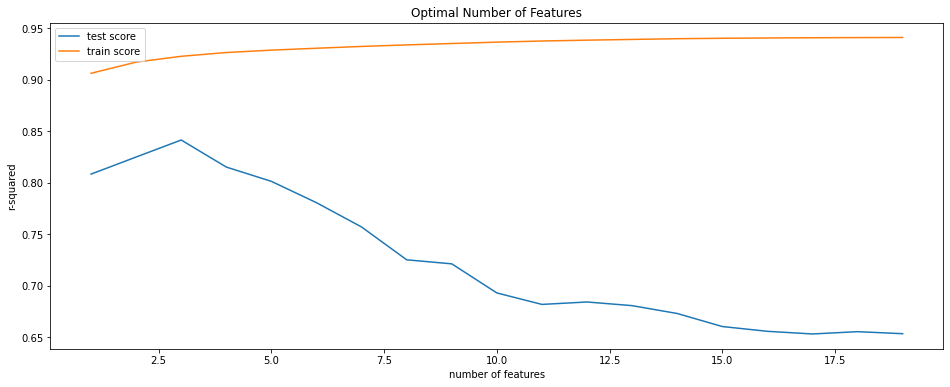

In [ ]:
X_train = df_reduced_dimensionality_scaled
y_train = list(df_target['DNAmAge'])

folds = KFold(n_splits = 10, shuffle = True, random_state = 42)

# step-2: specify range of hyperparameters to tune
hyper_params = [{'n_features_to_select': list(range(1, 20))}]


# step-3: perform grid search
# 3.1 specify model
lm = LinearRegression()
lm.fit(X_train, y_train)
rfe = RFE(lm)             

# 3.2 call GridSearchCV()
model_cv = GridSearchCV(estimator = rfe, 
                        param_grid = hyper_params, 
                        scoring= 'r2', 
                        cv = folds, 
                        verbose = 1,
                        return_train_score=True)      

# fit the model
model_cv.fit(X_train, y_train) 


# cv results
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results

# plotting cv results
plt.figure(figsize=(16,6))

plt.plot(cv_results["param_n_features_to_select"], cv_results["mean_test_score"])
plt.plot(cv_results["param_n_features_to_select"], cv_results["mean_train_score"])
plt.xlabel('number of features')
plt.ylabel('r-squared')
plt.title("Optimal Number of Features")
plt.legend(['test score', 'train score'], loc='upper left')



In [ ]:
X_total = df_reduced_dimensionality_scaled
y_total = list(df_target['DNAmAge'])
df_aux = pd.DataFrame(df_data['Edad'])
df_aux.columns = ['Edad_no_scaled']
X_total = pd.merge(X_total, df_aux, left_index=True, right_index=True)

## Results

In [ ]:
list_rmse_predict = []
list_rmse_age = []

def average(lst):
    return (sum(lst) / len(lst))

for i in range(100):
    X_train, X_test, y_train, y_test = train_test_split(X_total, y_total, test_size=0.25, random_state=i)
    X_edad = pd.DataFrame(X_test['Edad_no_scaled'])
    X_train = X_train.drop(columns = ['Edad_no_scaled'])
    X_test = X_test.drop(columns = ['Edad_no_scaled'])

    # final model
    n_features_optimal = 8

    lm = LinearRegression()
    lm.fit(X_train, y_train)

    rfe = RFE(lm, n_features_to_select=n_features_optimal)             
    rfe = rfe.fit(X_train, y_train)

    y_pred = lm.predict(X_test)

    results = pd.DataFrame()
    results['Edad'] = list(X_edad['Edad_no_scaled'])
    results['Predict'] = y_pred
    results['True'] = y_test
    
    list_rmse_age.append(math.sqrt(mean_squared_error(list(results['Edad']), list(results['True']))))
    list_rmse_predict.append(math.sqrt(mean_squared_error(list(results['Predict']), list(results['True']))))

print('El rmse entre la edad y el reloj biológico DNAmAge es: ' + str(average(list_rmse_age)))
print('El rmse entre el linear model y el reloj biológico DNAmAge es: ' + str(average(list_rmse_predict)))

El rmse entre la edad y el reloj biológico DNAmAge es: 12.207051288322567
El rmse entre el linear model y el reloj biológico DNAmAge es: 6.157338432520269


In [ ]:
results

,Edad,Predict,True
0,22,36.959102,36.790970
1,53,52.647122,58.814125
2,85,77.815735,75.590032
3,26,43.158001,46.399164
4,96,86.865501,80.701170
5,34,55.749829,47.379078
6,70,68.349535,70.672015
7,20,44.860410,36.897217
8,45,64.566817,57.030202
9,42,55.402618,56.879717
